tutor's email- nadine.t@queensu.ca

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
import pandas as pd
from zipfile import ZipFile
from io import BytesIO
import requests
import json
import keras
from PIL import Image
!pip install Pillow==9.5.0
from PIL.ExifTags import TAGS
!pip install requests
import os
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
!pip install tensorflow
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import os
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
!pip install requests
import requests


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#downloading multiple choice question file as q_TrainMultiple
# Fetch the zip file from the URL
url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip'
response = requests.get(url)

# Open the zip file from the response content
with ZipFile(BytesIO(response.content), 'r') as zip_file:
    # Get a list of files in the zip
    file_names = zip_file.namelist()

    # Create an empty dictionary to store the DataFrames
    dfs = {}

    # Iterate through each file in the zip
    for file_name in file_names:
        # Open each file within the zip
        with zip_file.open(file_name) as f:
            # Read the JSON data using json.load
            data = json.load(f)

            # Check if the data has a 'questions' key
            if 'questions' in data:
                # Create a DataFrame from the 'questions' key
                dfs[file_name] = pd.DataFrame(data['questions'])
            else:
                # Handle cases where 'questions' key is not present
                dfs[file_name] = pd.DataFrame(data)

# Access the tensors using their filenames as keys
q_TrainMultiple = dfs['MultipleChoice_abstract_v002_train2015_questions.json']

Downloading the training annotations to explore the file for relevant meta data

In [4]:
# downloading the annotation file as q_TrainAnnotations
url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip'
response = requests.get(url)

# Open the zip file from the response content
with ZipFile(BytesIO(response.content), 'r') as zip_file:
    # Get a list of files in the zip
    file_names = zip_file.namelist()

    # Create an empty dictionary to store the DataFrames
    dfs = {}

    # Iterate through each file in the zip
    for file_name in file_names:
      # Open each file within the zip
        with zip_file.open(file_name) as f:
            # Read the JSON data using json.load
            data = json.load(f)

            # Check if data is a dictionary and has the 'annotations' key
            if isinstance(data, dict) and 'annotations' in data:
                # Create a DataFrame from the 'annotations' key
                dfs[file_name] = pd.DataFrame(data['annotations'])
            else:
                # Handle cases where data is not a dictionary or 'annotations' key is not present
                dfs[file_name] = pd.DataFrame(data)

    # Access the tensors using their filenames as keys
    # Use the correct file name "abstract_v002_train2015_annotations.json"
    q_annotations = dfs['abstract_v002_train2015_annotations.json']

In [5]:

# Function to download and extract specific columns
def download_and_extract_columns(url, target_file, columns):
    print(f"Downloading data from {url}...")

    # Step 1: Download the zip file content from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: {response.status_code}")

    # Step 2: Open the zip file from the response content
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        # Get a list of files in the zip archive
        file_names = zip_file.namelist()

        # Step 3: Check if the target file exists in the zip archive
        if target_file not in file_names:
            raise FileNotFoundError(f"{target_file} not found in the zip archive.")

        # Step 4: Extract the target file and load the JSON data
        with zip_file.open(target_file) as f:
            data = json.load(f)

            # Step 5: Check if the data contains the 'questions' key
            if isinstance(data, dict) and 'questions' in data:
                # Create DataFrame from the 'questions' key
                questions_df = pd.DataFrame(data['questions'])

                # Step 6: Select the desired columns
                return questions_df[columns]
            else:
                raise KeyError(f"The key 'questions' not found in the JSON file.")

# URL for validation questions
val_questions_url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip'

# Name of the target file in the zip archive
target_file = 'MultipleChoice_abstract_v002_val2015_questions.json'

# Specify the columns to extract
columns_to_extract = ['question', 'multiple_choices', 'question_id', 'image_id']

# Step 7: Call the function to download and extract the specified columns
questions_data_df = download_and_extract_columns(val_questions_url, target_file, columns_to_extract)

# Step 8: Check if the DataFrame was successfully created
if questions_data_df is not None:
    # Step 9: Save the extracted columns to a CSV file
    questions_data_df.to_csv('questions_data.csv', index=False)
    print("The specified columns have been saved to 'questions_data.csv'.")

    # Display the first few rows of the DataFrame for verification
    print(questions_data_df.head())
else:
    print("Failed to extract data from the zip file.")


The specified columns have been saved to 'questions_data.csv'.
                                        question  \
0                             Is the dog asleep?   
1                    What is the man looking at?   
2             Is the man sitting on the armrest?   
3                          Did she bake the pie?   
4  What is resting on the table besides the pie?   

                                    multiple_choices  question_id  image_id  
0  [white, picnicking, yes, hot, dog and girl, bl...       275780     27578  
1  [monkey bars, drinking, dog, red, blue, son, b...       275781     27578  
2  [2, brown, wider, sitting, yes, marriage, red,...       275782     27578  
3  [golden girls, sky, 1, blue, 2, 4, no, feeding...       217680     21768  
4  [brown, air, cumulus, no, it is playing, wine ...       217681     21768  


In [6]:

# Function to download and extract specific columns from the annotations file
def download_and_extract_columns(url, target_file, columns):
    print(f"Downloading data from {url}...")

    # Step 1: Download the zip file content from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: {response.status_code}")

    # Step 2: Open the zip file from the response content
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        # Get a list of files in the zip archive
        file_names = zip_file.namelist()

        # Step 3: Check if the target file exists in the zip archive
        if target_file not in file_names:
            raise FileNotFoundError(f"{target_file} not found in the zip archive.")

        # Step 4: Extract the target file and load the JSON data
        with zip_file.open(target_file) as f:
            data = json.load(f)

            # Step 5: Check if the data contains the 'annotations' key
            if isinstance(data, dict) and 'annotations' in data:
                # Create DataFrame from the 'annotations' key
                annotations_df = pd.DataFrame(data['annotations'])

                # Step 6: Select the desired columns
                return annotations_df[columns]
            else:
                raise KeyError(f"The key 'annotations' not found in the JSON file.")

# URL for validation annotations
val_annotations_url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip'

# Name of the target file in the zip archive
target_file = 'abstract_v002_val2015_annotations.json'

# Specify the columns to extract
columns_to_extract = ['question_type', 'image_id', 'answer_type', 'question_id', 'multiple_choice_answer']

# Step 7: Call the function to download and extract the specified columns
annotations_data_df = download_and_extract_columns(val_annotations_url, target_file, columns_to_extract)

# Step 8: Check if the DataFrame was successfully created
if annotations_data_df is not None:
    # Step 9: Save the extracted columns to a CSV file
    annotations_data_df.to_csv('annotations_data.csv', index=False)
    print("The specified columns have been saved to 'annotations_data.csv'.")

    # Display the first few rows of the DataFrame for verification
    print(annotations_data_df.head())
else:
    print("Failed to extract data from the zip file.")



The specified columns have been saved to 'annotations_data.csv'.
       question_type  image_id answer_type  question_id multiple_choice_answer
0         is the dog     27578      yes/no       275780                    yes
1    what is the man     27578       other       275781                     tv
2         is the man     27578      yes/no       275782                    yes
3  none of the above     21768      yes/no       217680                    yes
4            what is     21768       other       217681             wine glass


In [7]:

# Function to download and extract specific columns from the questions file
def download_and_extract_columns(url, target_file, columns):
    print(f"Downloading data from {url}...")

    # Step 1: Download the zip file content from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: {response.status_code}")

    # Step 2: Open the zip file from the response content
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        # Get a list of files in the zip archive
        file_names = zip_file.namelist()

        # Step 3: Check if the target file exists in the zip archive
        if target_file not in file_names:
            raise FileNotFoundError(f"{target_file} not found in the zip archive.")

        # Step 4: Extract the target file and load the JSON data
        with zip_file.open(target_file) as f:
            data = json.load(f)

            # Step 5: Check if the data contains the 'questions' key
            if isinstance(data, dict) and 'questions' in data:
                # Create DataFrame from the 'questions' key
                questions_df = pd.DataFrame(data['questions'])

                # Step 6: Select the desired columns
                return questions_df[columns]
            else:
                raise KeyError(f"The key 'questions' not found in the JSON file.")

# URL for test questions
test_questions_url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Test_abstract_v002.zip'

# Name of the target file in the zip archive
target_file = 'MultipleChoice_abstract_v002_test2015_questions.json'

# Specify the columns to extract
columns_to_extract = ['question', 'multiple_choices', 'question_id', 'image_id']

# Step 7: Call the function to download and extract the specified columns
test_questions_data_df = download_and_extract_columns(test_questions_url, target_file, columns_to_extract)

# Step 8: Check if the DataFrame was successfully created
if test_questions_data_df is not None:
    # Step 9: Save the extracted columns to a CSV file
    test_questions_data_df.to_csv('test_questions_data.csv', index=False)
    print("The specified columns have been saved to 'test_questions_data.csv'.")

    # Display the first few rows of the DataFrame for verification
    print(test_questions_data_df.head())
else:
    print("Failed to extract data from the zip file.")


The specified columns have been saved to 'test_questions_data.csv'.
                                 question  \
0              What color are the chairs?   
1                      Is the man asleep?   
2                   What is on the table?   
3  How many bushes are in the background?   
4                  What are they playing?   

                                    multiple_choices  question_id  image_id  
0  [red, 4, 3, plates, brown, yellow, green, stan...       394560     39456  
1  [3, blue, 4, no, anger, white, 2, red, yes, on...       394561     39456  
2  [white, on sidewalk, salt and pepper, 3, yes, ...       394562     39456  
3  [blue, 1, 3, 40, dog, 10, 2, sun rays, red, ye...       479220     47922  
4  [yes, soccer, on man's head, frisbee, golf, mo...       479221     47922  


In [8]:
test_questions_data_df.head()

,question,multiple_choices,question_id,image_id
0,What color are the chairs?,"[red, 4, 3, plates, brown, yellow, green, stan...",394560,39456
1,Is the man asleep?,"[3, blue, 4, no, anger, white, 2, red, yes, on...",394561,39456
2,What is on the table?,"[white, on sidewalk, salt and pepper, 3, yes, ...",394562,39456
3,How many bushes are in the background?,"[blue, 1, 3, 40, dog, 10, 2, sun rays, red, ye...",479220,47922
4,What are they playing?,"[yes, soccer, on man's head, frisbee, golf, mo...",479221,47922


DATA PREPROCESSING IMAGE: The function below downloaded normalized and resized the abstract scene for training and validation images to ensure that they are ready for imput into deep learning. The resized image is 224 * 224 and the normalized image will be 255 pixels




In [9]:

# Set the directory where your images will be extracted in Google Drive
image_dir1 = '/content/drive/My Drive/scene_img_abstract_v002_train2015'  # Replace with your Google Drive path
save_file_path = '/content/drive/My Drive/image_data_train.npy'  # Path to save the image data

# URL of the zip file containing the images
url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip'

# Check if the image directory exists, else create it
if not os.path.exists(image_dir1):
    os.makedirs(image_dir1)
    print(f"Created directory {image_dir1}")

# Check if the image data file already exists to avoid reprocessing
if os.path.exists(save_file_path):
    print(f"Loading existing image data from {save_file_path}...")
    image_data_train = np.load(save_file_path)
else:
    # Download and extract images if not processed before
    print(f"Downloading and extracting images from {url}...")
    response = requests.get(url)
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        zip_file.extractall(image_dir1)
    print(f"Images extracted to {image_dir1}")

    # Initialize the image data list
    image_data_train = []

    # Loop through the image directory and process each image
    for image_file in tqdm(os.listdir(image_dir1)):
        if image_file.lower().endswith('.png'):  # Only process PNG files
            print(f'Processing: {image_file}')
            image_path = os.path.join(image_dir1, image_file)
            try:
                with Image.open(image_path) as img:
                    print(f"Image format: {img.format}, mode: {img.mode}")
                    img = img.resize((224, 224))  # Resize to 224x224
                    img_np = np.array(img) / 255.0  # Normalize the image
                    print(f"Image shape: {img_np.shape}")
                    image_data_train.append(img_np)
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
        else:
            print(f'Skipping non-png file: {image_file}')

    print(f"Number of images processed: {len(image_data_train)}")

    # Save the processed image data to Google Drive
    np.save(save_file_path, np.array(image_data_train))
    print(f"Image data saved to {save_file_path}")

# Check if any images were processed
if len(image_data_train) > 0:
    print(f"Shape of first image: {image_data_train[0].shape}")


Loading existing image data from /content/drive/My Drive/image_data_train.npy...
Shape of first image: (224, 224, 4)


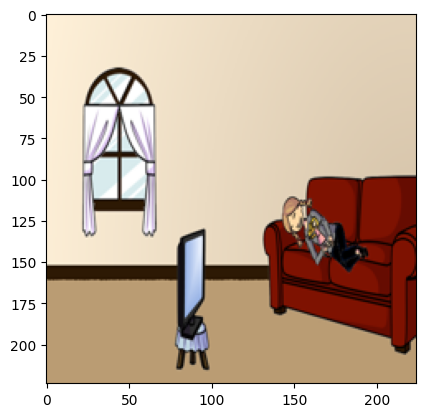

In [10]:
#view image from numpy array- np.array(image_data_train)

if len(image_data_train) > 0:
    image = Image.fromarray((np.array(image_data_train[0]) * 255).astype('uint8'))
    plt.imshow(image)
    plt.show()
else:
    print("Error: image_data does not have enough elements.")

# Consider checking the code in ipython-input-140-98b8b720e29d
# to ensure images are being loaded correctly into image_data.

In [12]:

# Set the directory where your images are stored in Google Drive
image_dir = '/content/drive/My Drive/scene_img_abstract_v002_val2015'  # Replace with your Google Drive image path
save_file_path = '/content/drive/My Drive/image_data_val.npy'  # Path to save the image data

# URL of the zip file containing the images
url = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip'

# Check if the directory exists, else create it
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    print(f"Created directory {image_dir}")

# Check if the directory is empty or doesn't have PNG files
if not any(fname.lower().endswith('.png') for fname in os.listdir(image_dir)):
    print(f"No images found in {image_dir}. Downloading from {url}...")
    response = requests.get(url)
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        zip_file.extractall(image_dir)
    print(f"Images extracted to {image_dir}")

# Check if image data already exists to avoid reprocessing
if os.path.exists(save_file_path):
    print(f"Loading existing image data from {save_file_path}...")
    image_data_val = np.load(save_file_path)
else:
    image_data_val = []

    # Loop through the image directory
    for image_file in tqdm(os.listdir(image_dir)):
        if image_file.lower().endswith('.png'):  # Only process PNG files
            print(f'Processing: {image_file}')
            image_path = os.path.join(image_dir, image_file)
            try:
                with Image.open(image_path) as img:
                    print(f"Image format: {img.format}, mode: {img.mode}")
                    img = img.resize((224, 224))  # Resize to 224x224
                    img_np = np.array(img) / 255.0  # Normalize the image
                    print(f"Image shape: {img_np.shape}")
                    image_data_val.append(img_np)
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
        else:
            print(f'Skipping non-png file: {image_file}')

    print(f"Number of images processed: {len(image_data_val)}")

    # Save the processed image data to Google Drive
    np.save(save_file_path, np.array(image_data_val))
    print(f"Image data saved to {save_file_path}")

# Check if any images were processed
if len(image_data_val) > 0:
    print(f"Shape of first image: {image_data_val[0].shape}")


Loading existing image data from /content/drive/My Drive/image_data_val.npy...
Shape of first image: (224, 224, 4)


In [ ]:

# Set the directory where your test images will be stored
image_dir_test = '/content/drive/My Drive/scene_img_abstract_v002_test2015'  # Replace with your Google Drive path
save_file_path_test = '/content/drive/My Drive/image_data_test.npy'  # Path to save the test image data

# URL of the zip file containing the test images
url_test = 'https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_test2015.zip'

# Check if the image directory exists, else create it
if not os.path.exists(image_dir_test):
    os.makedirs(image_dir_test)
    print(f"Created directory {image_dir_test}")

# Check if the directory is empty or doesn't have PNG files
if not any(fname.lower().endswith('.png') for fname in os.listdir(image_dir_test)):
    print(f"No images found in {image_dir_test}. Downloading from {url_test}...")
    response = requests.get(url_test)
    with ZipFile(BytesIO(response.content), 'r') as zip_file:
        zip_file.extractall(image_dir_test)
    print(f"Images extracted to {image_dir_test}")

# Check if image data already exists to avoid reprocessing
if os.path.exists(save_file_path_test):
    print(f"Loading existing test image data from {save_file_path_test}...")
    image_data_test = np.load(save_file_path_test)
else:
    image_data_test = []

    # Loop through the image directory and process images
    for image_file in tqdm(os.listdir(image_dir_test)):
        if image_file.lower().endswith('.png'):  # Only process PNG files
            image_path = os.path.join(image_dir_test, image_file)
            with Image.open(image_path) as img:
                img = img.resize((224, 224))  # Resize to 224x224
                img_np = np.array(img) / 255.0  # Normalize the image
                image_data_test.append(img_np)
        else:
            print(f'Skipping non-png file: {image_file}')

    # Convert the list to a numpy array and save it
    image_data_test = np.array(image_data_test)
    np.save(save_file_path_test, image_data_test)
    print(f"Processed test image data saved to {save_file_path_test}")

# Check if any images were processed
if len(image_data_test) > 0:
    print(f"Shape of first test image: {image_data_test[0].shape}")


EXPLORATORY DATA ANALYSIS

In [ ]:
#viewing the top 5 multple choice questions
q_TrainMultiple.head()

In [13]:
q_TrainMultiple.shape

(60000, 4)

In [14]:
q_TrainMultiple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_id          60000 non-null  int64 
 1   question          60000 non-null  object
 2   multiple_choices  60000 non-null  object
 3   question_id       60000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ MB


In [15]:
#length of choices in a multiple choice column
len(q_TrainMultiple['multiple_choices'][59999])

18

In [16]:
# Check if all lists in 'multiple_choices' column have the same length
def check_list_lengths(df, column_name):
  """
  Checks if all lists in the specified column of a DataFrame have the same length.
  """
  lists = df[column_name].tolist()
  it = iter(lists)
  the_len = len(next(it))
  return all(len(l) == the_len for l in it)

# Call the function to check the lengths
if check_list_lengths(q_TrainMultiple, 'multiple_choices'):
  print('All lists have the same length.')
else:
  print('Not all lists have the same length.')

All lists have the same length.


In [17]:
#checking for null values in q_TrainMultiple
q_TrainMultiple.isnull().sum()

,0
image_id,0
question,0
multiple_choices,0
question_id,0


In [18]:
# Viewing the top 5 annotations
q_annotations.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,who,man,"[{'answer': 'old person', 'answer_confidence':...",11779,other,117792
1,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",11779,other,117790
2,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",11779,other,117791
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",5536,yes/no,55360
4,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",5536,other,55361


In [19]:
q_annotations.shape

(60000, 6)

In [20]:
#viewing the data types
q_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   question_type           60000 non-null  object
 1   multiple_choice_answer  60000 non-null  object
 2   answers                 60000 non-null  object
 3   image_id                60000 non-null  int64 
 4   answer_type             60000 non-null  object
 5   question_id             60000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [21]:
# viewing answers
q_annotations['answers'][0]

[{'answer': 'old person', 'answer_confidence': 'maybe', 'answer_id': 1},
 {'answer': 'man', 'answer_confidence': 'maybe', 'answer_id': 2},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 3},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 4},
 {'answer': 'old man', 'answer_confidence': 'yes', 'answer_id': 5},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 6},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 7},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 8},
 {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 9},
 {'answer': 'grandpa', 'answer_confidence': 'yes', 'answer_id': 10}]

In [22]:
#checking for other variables in answer_type
q_annotations['answer_type'].unique()

array(['other', 'yes/no', 'number'], dtype=object)

In [23]:
#checking the distribution of question column character count
q_TrainMultiple['question'].str.len().describe()





,question
count,60000.000000
mean,30.012083
std,10.118685
min,9.000000
25%,23.000000
50%,28.000000
75%,35.000000
max,100.000000


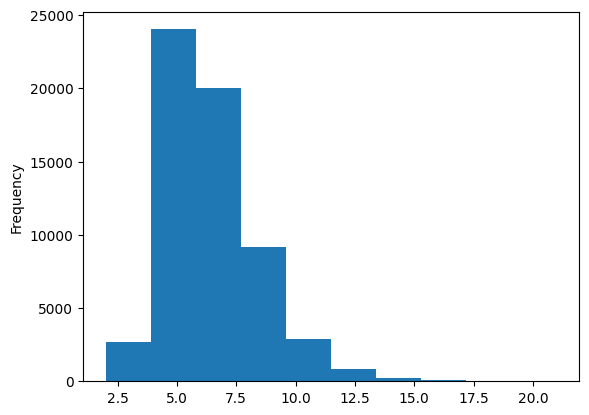

In [24]:

# a chart graphical representation using the character count on X axis
q_TrainMultiple['question'].str.split().str.len().plot(kind='hist')
plt.show()



In [25]:
#checking the distribution of the question column first words
q_TrainMultiple['question'].str.split().str[0].value_counts()


,count
question,
What,19907
Is,16225
How,9026
Are,4480
Where,3139
...,...
Her,1
That,1
Their,1


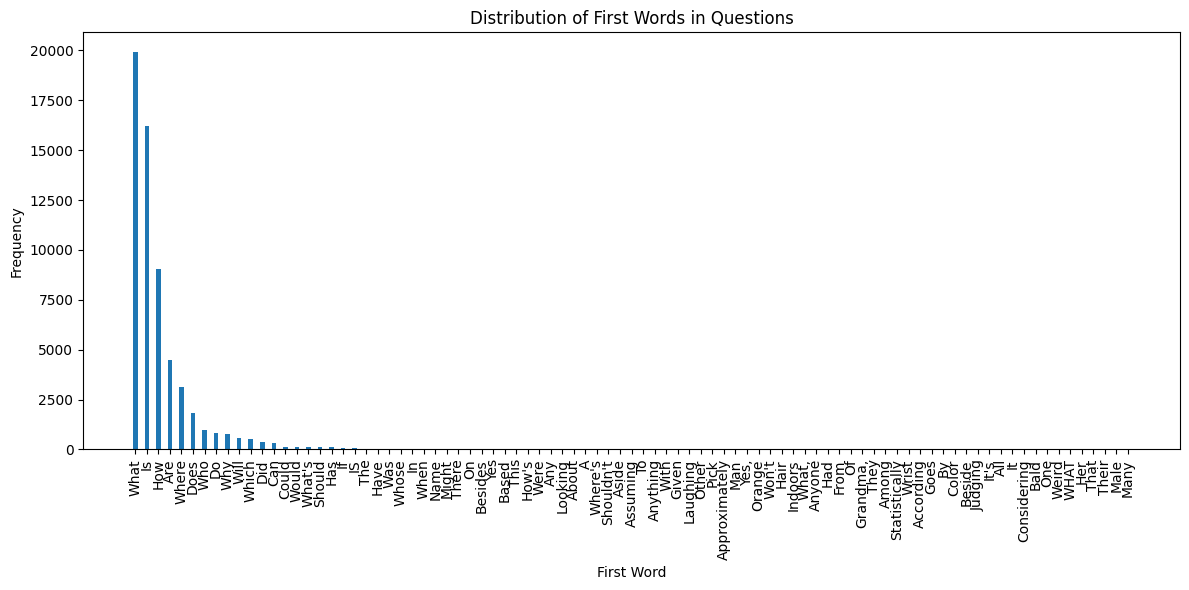

In [26]:

import matplotlib.pyplot as plt

# Calculate value counts for the first words
first_word_counts = q_TrainMultiple['question'].str.split().str[0].value_counts()

# Get the unique first words and their counts
first_words = first_word_counts.index
counts = first_word_counts.values

# Create a bar plot with custom spacing
plt.figure(figsize=(12, 6))  # Adjust figure size for better visibility

# Create an array for x-axis positions with spacing
x_positions = np.arange(len(first_words)) * 2  # Adjust the multiplier (2 in this case) for desired spacing

plt.bar(x_positions, counts)  # Use x_positions for x-axis values

# Set x-axis labels and rotate them for readability
plt.xticks(x_positions, first_words, rotation=90)

plt.xlabel("First Word")
plt.ylabel("Frequency")
plt.title("Distribution of First Words in Questions")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [27]:
# Get the first two words of each question
first_two_words = q_TrainMultiple['question'].str.split().str[:2].apply(lambda x: ' '.join(x))

# Calculate value counts for the first two words
first_two_words_counts = first_two_words.value_counts()

# Display descriptive statistics for the first two words
print(first_two_words_counts.describe())


count     1099.000000
mean        54.595086
std        554.628718
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max      10970.000000
Name: count, dtype: float64


In [28]:
#multiple_choice_answer column character count
q_annotations['multiple_choice_answer'].str.len().describe()

,multiple_choice_answer
count,60000.000000
mean,3.931033
std,2.942038
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,49.000000


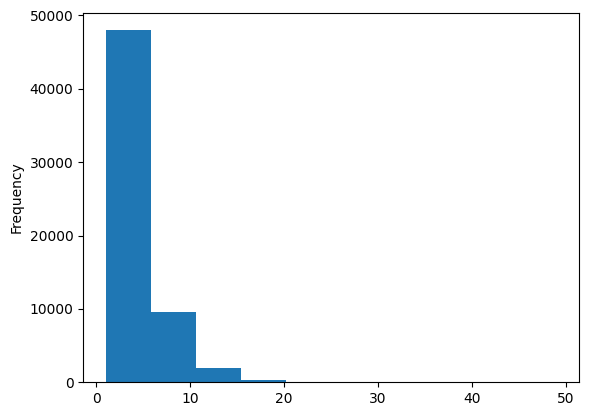

In [29]:
#graphical representation multiple_choice_answer column character count
q_annotations['multiple_choice_answer'].str.len().plot(kind='hist')
plt.show()

In [30]:
#multiple_choice_answer column word count
q_annotations['multiple_choice_answer'].str.split().str.len().describe()

,multiple_choice_answer
count,60000.000000
mean,1.088050
std,0.375188
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,9.000000


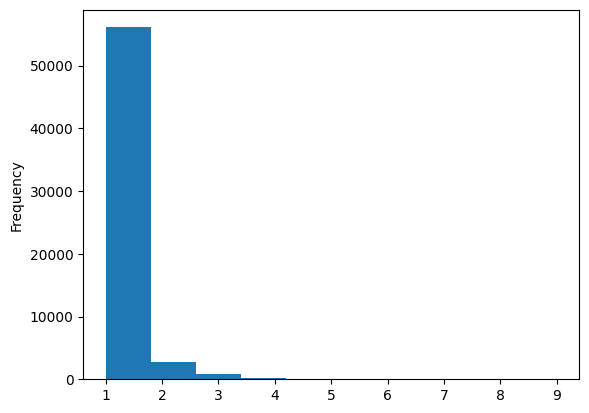

In [31]:
#graphical representation of multiple_choice_answer column word count
q_annotations['multiple_choice_answer'].str.split().str.len().plot(kind='hist')
plt.show()

UNBALANCED DATA SET FOR THE ANSWER_TYPE COLUMN BUT MAY NOT REQUIRE TREATMENT BASED ON THIS USE CASE???

In [32]:
# viewing answer_type yes/no
q_annotations['answer_type'].str.contains('yes/no').sum()


24396

In [33]:
# viewing answer_type other
q_annotations['answer_type'].str.contains('other').sum()

26916

In [34]:
# viewing answer type numer
q_annotations['answer_type'].str.contains('number').sum()

8688

In [35]:
#checking if there is null in q_annotation
q_annotations.isnull().sum()

,0
question_type,0
multiple_choice_answer,0
answers,0
image_id,0
answer_type,0
question_id,0


In [36]:
# checking the unique question_type
q_annotations['question_type'].unique()

array(['who', 'where is the', 'is this', 'what kind of',
       'what color is the', 'who is', 'how', 'does', 'what is',
       'what is the', 'where are the', 'what', 'is the man',
       'what is the woman', 'is the cat', 'do', 'is the', 'is that',
       'how many pillows', 'is there', 'how many people are', 'is',
       'is there a', 'what is the boy', 'are they', 'how many bushes',
       'what is the girl', 'none of the above', 'how many',
       'what is on the', 'is the old man', 'does the', 'are the',
       'what are the', 'is the dog', 'is it', 'is the woman',
       'what color is', 'what is the man', 'what color', 'what type of',
       'what is the dog', 'what is in the', 'is the girl',
       'are there any', 'is the lady', 'is the sun', 'what color are the',
       'how many animals are', 'how many clouds are', 'are there',
       'is this a', 'why is the', 'is the baby', 'are the people',
       'what is the little', 'will the', 'can', 'how many plants are',
       'is

In [37]:
#checking the sum of the unique question_type
q_annotations['question_type'].value_counts()

,count
question_type,
how many,5956
what color is the,4184
is the,3436
where is the,2621
what,2329
...,...
how many birds are,188
what color is,183
what is the baby,179


A high correlation between image_id and question_id in your dataset could have some implications for deep learning training, particularly if you're building models to generate questions from images or vice versa. Here's a breakdown of potential implications and how to address them:
Potential Implications

Data Leakage: A high correlation might indicate that your question_id is directly derived from or strongly related to the image_id. This can lead to data leakage, where information from the image_id unintentionally influences the model's predictions about the question_id. The model might learn to exploit this relationship instead of learning the underlying patterns in the data. This could result in overly optimistic performance during training that doesn't generalize well to new, unseen data.

Bias and Limited Generalization: If your model learns a strong association between specific image IDs and question IDs, it may struggle to generalize to new images or questions that don't follow this pattern. This is especially problematic if you plan to deploy your model in a real-world setting where it will encounter a wider range of images and questions.

How to Address the Issue
Analyze the Relationship: Investigate why the correlation is high.
Is question_id generated from image_id? If so, you likely have data leakage.
Are questions clustered by image? For example, do multiple questions relate to the same image? This could be a natural correlation depending on your data collection process.

Consider Removing or Transforming Features:
Remove question_id: If it's simply an identifier with no semantic meaning, it might be irrelevant for your model and could be removed.
Transform image_id: If image_id is numeric and its magnitude influences the correlation, consider encoding it differently (e.g., one-hot encoding) to reduce its direct influence on the model.

Data Augmentation and Diversification:
Introduce new images and questions that don't follow the existing correlation pattern.

Use data augmentation techniques to create variations of existing images and questions.
Careful Evaluation:
Use a robust evaluation strategy (e.g., cross-validation) to ensure your model generalizes well.

Pay attention to performance on a held-out test set that is representative of the real-world data distribution.

Example:
Let's say you're building a model to generate a question from an image. If question_id is simply a sequential number assigned to each question related to an image, you might encounter the following:
Image 1: image_id = 1, question_ids = 1, 2, 3
Image 2: image_id = 2, question_ids = 4, 5, 6
The model could learn that higher image_id values are associated with higher question_id values without truly understanding the content of the images or the meaning of the questions.
In this case, removing question_id from your training data would likely be the best approach.

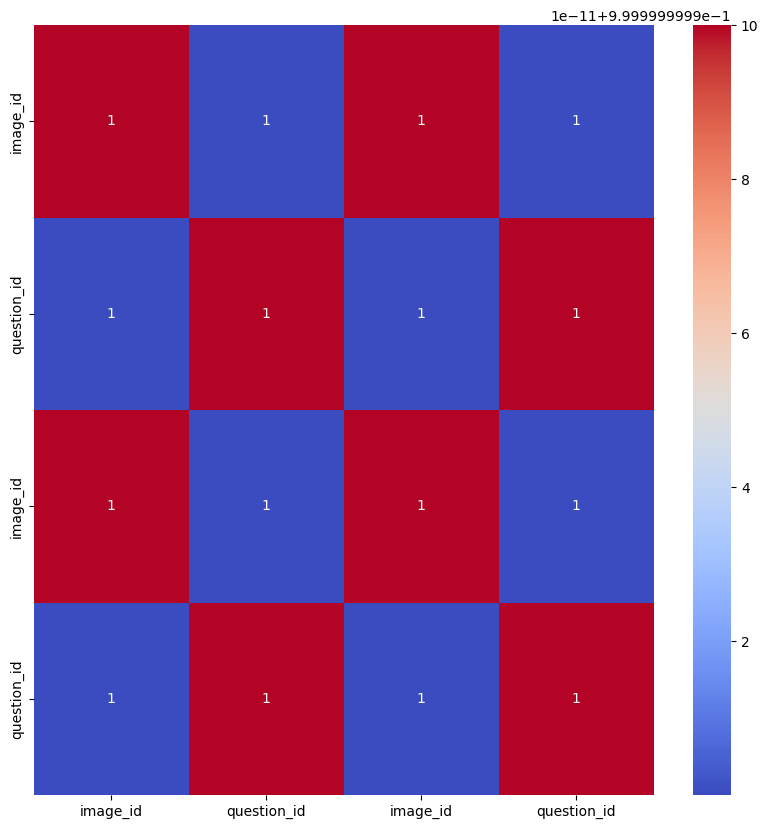

In [38]:
#using Keras heatmap boxes concanate to show correlation matrix between q_trainMultiple and q_annotations columns
!pip install seaborn # install the seaborn library
import seaborn as sns # import the seaborn library and alias it as 'sns'
import matplotlib.pyplot as plt # import matplotlib.pyplot and alias it as 'plt'
import pandas as pd # import the pandas library and alias it as 'pd'

#Concatenate them
correlation_matrix = pd.concat([q_TrainMultiple, q_annotations], axis=1)

# Select only numeric columns for correlation analysis
correlation_matrix = correlation_matrix.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = correlation_matrix.corr()

#plot the graph
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


DATA CLEANING & FE:

*post-processing of Spelling correction (using Bing Speller) of question and answer strings.*

Post-processing Question normalization (first char uppercase, last char ‘?’)- converting text to lowercase and removing special characters and punctuations. This makes tokenization more effective.

Answer normalization (all chars lowercase, no period except as decimal point, number words —> digits, strip articles (a, an the))- removing numbers and punctuations to make tokenization more effective.

Adding apostrophe if a contraction is missing it (e.g., convert "dont" to "don't"- removing punctuations to make tokenization more effective

In [39]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from gensim.models import KeyedVectors
import tensorflow as tf

In [40]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
# Text preprocessing
def preprocess_text(df, columns):
    for col in columns:
        df[col] = df[col].str.lower()
        df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        #df[col] = df[col].apply(lambda x: re.sub(r'\d+', '', x))
        df[col] = df[col].apply(lambda x: x.replace("'", "").strip())
        #df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df

In [42]:
# Merge datasets
q_TrainMultiple = pd.merge(q_TrainMultiple, q_annotations, on=['image_id', 'question_id'])
questions_val_data = pd.merge(questions_data_df, annotations_data_df, on=['image_id', 'question_id'])

In [43]:
# Preprocess training, validation, and test data
q_TrainMultiple = preprocess_text(q_TrainMultiple, ['question'])
questions_val_data = preprocess_text(questions_val_data, ['question'])
test_questions_data_df = preprocess_text(test_questions_data_df, ['question'])

In [44]:
# remove numbers from the questions column
q_TrainMultiple['question'] = q_TrainMultiple['question'].apply(lambda x: re.sub(r'\d+', '', x))
questions_val_data['question'] = questions_val_data['question'].apply(lambda x: re.sub(r'\d+', '', x))
test_questions_data_df['question'] = test_questions_data_df['question'].apply(lambda x: re.sub(r'\d+', '', x))

In [45]:
#deleting stop words from question
q_TrainMultiple['question'] = q_TrainMultiple['question'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
questions_val_data['question'] = questions_val_data['question'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_questions_data_df['question'] = test_questions_data_df['question'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [46]:
#Stemming question columns in q_TrainMultiple, questions_val_data and test_questions_data_df
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
q_TrainMultiple['question'] = q_TrainMultiple['question'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
questions_val_data['question'] = questions_val_data['question'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
test_questions_data_df['question'] = test_questions_data_df['question'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))



In [47]:
# Tokenization and padding
def tokenize_and_pad(df, column, tokenizer, maxlen=100):
    texts = df[column].values.tolist()
    texts = [str(item) for item in texts]
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(q_TrainMultiple['question'].values.tolist())
tokenizer.fit_on_texts(questions_val_data['question'].values.tolist())
tokenizer.fit_on_texts(test_questions_data_df['question'].values.tolist())


In [48]:
# Tokenize and pad all text data
question_padded_train = tokenize_and_pad(q_TrainMultiple, 'question', tokenizer)
question_padded_val = tokenize_and_pad(questions_val_data, 'question', tokenizer)
question_padded_test = tokenize_and_pad(test_questions_data_df, 'question', tokenizer)


In [49]:
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Fit MultiLabelBinarizer with a limited number of classes
mlb = MultiLabelBinarizer()
answer_train = mlb.fit_transform(q_TrainMultiple['multiple_choices'])

# 2. Get the desired number of classes (18 in this case)
num_classes = 18

# 3. Select the top 'num_classes' most frequent classes
top_classes = [mlb.classes_[i] for i in range(num_classes)]

# 4. Re-fit MultiLabelBinarizer with the selected classes
mlb = MultiLabelBinarizer(classes=top_classes)
answer_train = mlb.fit_transform(q_TrainMultiple['multiple_choices'])

# 5. Transform validation and test data using the re-fitted binarizer
answer_val = mlb.transform(questions_val_data['multiple_choices'])
answer_test = mlb.transform(test_questions_data_df['multiple_choices'])

# 6. Now, the shape should be compatible with 18 columns
print(f"Original shape of answer_train: {answer_train.shape}")
# Expected output: (60000, 18)

# 7. Reshape if needed (should not be necessary now)
# answer_train = answer_train.reshape(answer_train.shape[0], -1)
# answer_val = answer_val.reshape(answer_val.shape[0], -1)
# answer_test = answer_test.reshape(answer_test.shape[0], -1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['1 yard', '1 year', '1,234', '1,254', '1,274', '1.2 miles', '1/2', '1/2 in', '1/4', '1/8 inch', '10', '10 am', '10 feet', '10 ft', '10 minutes', '10 mph', '10 pounds', '10 women', '10 years', '10,000 f', '100', '100 feet', '100 lbs', '100 pounds', '100 years', '100 years old', '1000', '1000 feet', "1000's", '10000', '10000 fahrenheit', '100000', '100000000000000', '10:00 pm', '11', '112', '115', '11:20', '12', '12 feet', '12 inches', '12 mph', '12 years', '12 years old', '120', '120 pounds', '1209', '123', '124', '125 mph', '129', '12:00', '12:00 pm', '12:03', '12:05', '13', '14', '14 on each', '140 pounds', '144', '15', '15 years', '150', '150 pounds', '16', '163753', '1689314412', '17', '175', '18', '183', '183638', '189', '19', '190', '1979', '1985', '1990', '1:34', '1st', '2', '2 and 5', '2 birds 1 dog', '2 boys', '2 days', '2 feet', '2 ft', '2 girls', '2 glasses', '2 hours'

Original shape of answer_train: (60000, 18)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [',4', '.0', '1 is hidden', '1 month', '1 yard', '1 year', '1-6', '10', '10 - 12', '10 feet', '10 feet long', '10 foot', '10 minutes', '10 mph', "10 o'clock", '10 plants', '10 speed', '10 years', '10%', '100', '100 degrees', '100 pounds', "100's", '1000', '100000', '1000000 years', '101', '102', '105', '11', '1111110', '114', '11:00', '11:43', '12', '12 feet', '12 noon', '12 pm', '1200', '122', '1234', '12356', '125', '12:00', '12:00 noon', '12:45', '13', '1359', '14', '140', '145', '15', '150', '1500', '16', '17', '18', '18-30', '180', '19', '1956', '1970', '1989', '1:00', '2', '2 books', '2 boys', '2 crows', '2 feet', '2 fireplaces', '2 girls', '2 hours', '2 little girls', '2 men', '2 minutes', '2 on right', '2 people', '2 people are drinking', '2 pillows', '2 plates', '2 were born', '2 windows', '2 woman', '2 women', '2 years', '20', '200', '2000', '2015', '206', '20s', '20th'

In [50]:
answer_train.shape

(60000, 18)

In [51]:
#label encoding of multiple_choice_answer columns
from sklearn.preprocessing import LabelEncoder

# 1. Fit LabelEncoder on all unique values from train, val, and test data
#label encoding of multiple_choice_answer columns
from sklearn.preprocessing import LabelEncoder

# 1. Fit LabelEncoder on all unique values from train, val, and test data
all_answers = list(q_TrainMultiple['multiple_choice_answer'].unique()) + \
              list(questions_val_data['multiple_choice_answer'].unique()) + \
              [] # Add an empty list to avoid syntax error

le = LabelEncoder()
le.fit(all_answers)

# 2. Transform multiple_choice_answer columns for all datasets
q_annotations['multiple_choice_answer'] = le.transform(q_TrainMultiple['multiple_choice_answer'])
questions_val_data['multiple_choice_answer'] = le.transform(questions_val_data['multiple_choice_answer'])




In [52]:

# One-hot encoding for answer types and image ids
image_id_train = pd.get_dummies(q_TrainMultiple['image_id']).values
image_id_val = pd.get_dummies(questions_val_data['image_id']).values
image_id_test = pd.get_dummies(test_questions_data_df['image_id']).values

In [53]:
# Download and load pre-trained Word2Vec model
model_path = './word2vec-google-news-300.model'
if not os.path.exists(model_path):
    word2vec_model = api.load("word2vec-google-news-300")
    word2vec_model.save(model_path)
word2vec_model = KeyedVectors.load(model_path)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [54]:
import nltk

nltk.download('wordnet')

# Applying lemmatization on the question column
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
q_TrainMultiple['question'] = q_TrainMultiple['question'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
questions_val_data['question'] = questions_val_data['question'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test_questions_data_df['question'] = test_questions_data_df['question'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [55]:
#word2vec vocab size
vocab_size


4340

Custom Loss Function

In [56]:
import tensorflow as tf

# Define the maximum question length. Replace 100 with your desired value.
max_question_length = 100

image_feature_shape = (None, 224, 224, 3) # Adjust this based on your model's output shape

def dynamic_sparse_categorical_crossentropy(y_true, y_pred, answer_set):
    """
    Custom loss function to handle dynamic answer sets.
    Maps the correct answer to the position in the dynamic answer set.
    """
    # Find the index of the correct answer in the dynamic answer set for each sample
    mapped_labels = tf.map_fn(lambda x: tf.where(tf.equal(answer_set, x))[0, 0], y_true)

    # Apply sparse categorical crossentropy with the dynamically mapped labels
    return tf.keras.losses.sparse_categorical_crossentropy(mapped_labels, y_pred)


    """
    Custom loss function to handle dynamic answer sets.
    Maps the correct answer to the position in the dynamic answer set.
    """
    # Find the index of the correct answer in the dynamic answer set for each sample
    mapped_labels = tf.map_fn(lambda x: tf.where(tf.equal(answer_set, x))[0, 0], y_true)

    # Apply sparse categorical crossentropy with the dynamically mapped labels
    return tf.keras.losses.sparse_categorical_crossentropy(mapped_labels, y_pred)


Adjust the Model for Dynamic Output
In the model, you will keep the output layer to always predict 18 choices, but the choices themselves will be dynamic per sample.

In [57]:
def create_vqa_model(max_question_length, image_feature_shape, vocab_size, embedding_dim, embedding_matrix):
    # Define model input layers
    question_input = Input(shape=(max_question_length,), name='question_input')
    # Pass image_feature_shape directly as the shape
    image_input = Input(shape=image_feature_shape[1:], name='image_input')  # Corrected input shape
    image_id_input = Input(shape=(1,), name='image_id_input')
    answer_input = Input(shape=(18,), name='answer_input')  # Dynamic set of 18 answers


    # dense layers to process image and text inputs
    question_features = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(question_input)  # Initialize with pre-trained embeddings
    question_features = layers.LSTM(128)(question_features)

       # Reshape or flatten the image features before concatenation
    # Assuming image_input is (None, 224, 224, 3)
    image_features = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    image_features = layers.MaxPooling2D((2, 2))(image_features)
    image_features = layers.Conv2D(64, (3, 3), activation='relu')(image_features)
    image_features = layers.MaxPooling2D((2, 2))(image_features)
    image_features = layers.Flatten()(image_features) # Flatten the image features
    image_features = layers.Dense(128, activation='relu')(image_features) # Pass through a Dense layer

    # Combine question, image, and answer features
    x = layers.Concatenate()([question_features, image_features])


    # Add further dense layers and finally output layer
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(18, activation='softmax')(x)  # Always output 18 classes

    # Define the model
    model = Model(inputs=[question_input, image_input, image_id_input, answer_input], outputs=output)

    # Compile the model using the custom loss function
    #model.compile(optimizer='adam', loss=dynamic_sparse_categorical_crossentropy)  # You might need to adjust this

    return model

Adjust Data Processing
Before training, for each sample, you will need to:

Generate the dynamic set of 18 answer choices.
Map the correct answer to its position within these choices.

In [58]:
import tensorflow as tf

# Import the 'layers' module from Keras
from tensorflow import keras
from tensorflow.keras import layers
# Import Input directly from tensorflow.keras
from tensorflow.keras import Input # Import Input

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Building the model
model = create_vqa_model(max_question_length, image_feature_shape,vocab_size,embedding_dim,embedding_matrix)


# Sampling training data
sample_size = 10000
batch_size = 32

indices = np.random.permutation(sample_size)
question_padded_train_sample = question_padded_train[:sample_size][indices]
answer_train_sample = answer_train[:sample_size][indices]
image_data_train_sample = image_data_train[:sample_size][indices]
image_id_train_sample = np.argmax(image_id_train[:sample_size], axis=1)[indices]


# Assuming 'q_TrainMultiple['multiple_choice_answer']' contains strings,
# Create a mapping from unique answers to numerical labels.

#Get all unique answers from the column
all_answers = q_TrainMultiple['multiple_choice_answer'].unique()

# Create a dictionary to map answer strings to numerical labels
answer_to_label = {answer: i for i, answer in enumerate(all_answers)}

# Convert answers to numerical labels using the mapping
correct_answer_sample = q_TrainMultiple['multiple_choice_answer'][:sample_size].map(answer_to_label).values[indices]

# Prepare validation data samples similar to training data samples
# Assuming you have variables like question_padded_val, image_data_val, etc. for validation data
question_padded_val_sample = question_padded_val[:sample_size][indices] # Use same indices or generate new ones for validation
image_data_val_sample = image_data_val[:sample_size][indices]  # Use same indices or generate new ones for validation
image_id_val_sample = np.argmax(image_id_val[:sample_size], axis=1)[indices] # Use same indices or generate new ones for validation

# Preprocess image data
image_data_train_sample = np.array([img[:, :, :3] if img.shape[-1] == 4 else img for img in image_data_train_sample])
image_data_val = np.array([img[:, :, :3] if img.shape[-1] == 4 else img for img in image_data_val])

# Generate label mapping (ensure this includes all possible answer labels)
# Assuming 'correct_answer_sample' and 'val_correct' are numpy arrays of the answers.
unique_labels = np.unique(correct_answer_sample)
label_mapping = {label: idx for idx, label in enumerate(sorted(unique_labels)) if idx < 18}

# Map labels to the valid range [0, 17]
correct_answer_sample = np.vectorize(lambda x: label_mapping.get(x, 17))(correct_answer_sample)
val_correct = np.vectorize(lambda x: label_mapping.get(x, 17))(questions_val_data['multiple_choice_answer'].values)

# Ensure labels are within the valid range [0, 17]
correct_answer_sample = np.clip(correct_answer_sample, 0, 17)
val_correct = np.clip(val_correct, 0, 17)

# Callbacks for saving and learning rate scheduling
model_save_path = '/content/drive/MyDrive/overfit_best_model.h5'
callbacks = [
    ModelCheckpoint(model_save_path, monitor='accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='loss', patience=10)
]

In [59]:
#compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
#training to overfit the training dataset
history = model.fit([question_padded_train_sample, image_data_train_sample, image_id_train_sample, answer_train_sample], correct_answer_sample, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 1.2321 - accuracy: 0.5204

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 139s 436ms/step - loss: 1.2321 - accuracy: 0.5204 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 136s 435ms/step - loss: 1.0134 - accuracy: 0.5861 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 136s 433ms/step - loss: 0.8731 - accuracy: 0.6522 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 137s 436ms/step - loss: 0.4765 - accuracy: 0.8231 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 138s 441ms/step - loss: 0.1032 - accuracy: 0.9692 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 136s 436ms/step - loss: 0.0251 - accuracy: 0.9945 - lr: 0.0010
Epoch 7/100
313/313 [==============================] - 139s 443ms/step - loss: 0.0057 - accuracy: 0.9992 - lr: 0.0010
Epoch 8/100
313/313 [==============================] - 139s 443ms/step - loss: 0.0022 - accuracy: 0.9997 - lr: 0.0010
Epoch 9/100
313/313 [==============================] - 139s 444ms/st

For Classification: You should keep the Y variable in its original form. For multi-class classification, use appropriate label encoding techniques such as:

One-Hot Encoding: For categorical labels, one-hot encode them for models that expect a multi-class format.
Sparse Categorical Encoding: If using sparse_categorical_crossentropy, leave the labels as integer values representing each class.

In [61]:
#loading overfit_best_model.h5 from google drive
#history = tf.keras.models.load_model('/content/drive/MyDrive/overfit_best_model.h5')


In [62]:
# Get the number of samples in validation data
num_val_samples = image_data_val.shape[0]  # Use the size of image_data_val

# Sample validation data with the correct size
indices_val = np.random.permutation(num_val_samples)[:sample_size]
question_padded_val_sample = question_padded_val[indices_val]
image_data_val_sample = image_data_val[indices_val]
image_id_val_sample = np.argmax(image_id_val[:num_val_samples], axis=1)[indices_val] # Limit image_id_val indexing
# Ensure 'val_correct' is also sampled to have 'sample_size' or num_val_samples entries
val_correct = val_correct[indices_val]  # Sample 'val_correct' using 'indices_val

In [63]:
# Assuming you also need 'answer_val_sample' for validation:
# Ensure you have 'answer_val' prepared
answer_val_sample = answer_val[indices_val] # Or the process to get answer val
# Assuming you also need 'answer_val_sample' for validation:
# Ensure you have 'answer_val' prepared
answer_val_sample = answer_val[indices_val] # Or the process to get answer val

# Now evaluate with 4 input elements, similar to fit
model.evaluate([question_padded_val_sample, image_data_val_sample, image_id_val_sample, answer_val_sample], val_correct)

313/313 [==============================] - 24s 76ms/step - loss: 6.6149 - accuracy: 0.5156


[6.614928245544434, 0.5156000256538391]

In [ ]:
# Import necessary functions
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Get predictions from the model
predicted_probs = model.predict([question_padded_val_sample, image_data_val_sample, image_id_val_sample, answer_val_sample])

# Convert probabilities to class labels (assuming binary classification)
# If you have multi-class classification, adjust the threshold or use argmax
predicted_labels = (predicted_probs > 0.5).astype(int)

# If predicted_labels is multilabel-indicator, convert to multiclass
# This assumes each sample belongs to only one class
if predicted_labels.ndim > 1 and predicted_labels.shape[1] > 1:
    predicted_labels = np.argmax(predicted_labels, axis=1)

# Assuming 'val_correct' holds your true labels
true_labels = val_correct

# If true_labels is multilabel-indicator, convert to multiclass
# This assumes each sample belongs to only one class
if true_labels.ndim > 1 and true_labels.shape[1] > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Now calculate the F1 score and confusion matrix using the class labels
print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(true_labels, predicted_labels)}")

In [ ]:
#graphically compare training and validation loss and accuracy
'''import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()'''

In [ ]:
# Function to load the image data once and not reload every time
'''def load_image_data(filename, default_path):
    # Check if the file exists in the current directory
    if os.path.exists(filename):
        print(f"Loading {filename} from current directory...")
        return np.load(filename)
    else:
        # If not found, load it from the provided default path
        if os.path.exists(default_path):
            print(f"Loading {filename} from {default_path}...")
            return np.load(default_path)
        else:
            raise FileNotFoundError(f"{filename} not found in both current directory and {default_path}")

# Load train image data
image_data_train = load_image_data('image_data_train.npy', '/content/drive/MyDrive/image_data_train.npy')

# Load validation image data
image_data_val = load_image_data('image_data_val.npy', '/content/drive/MyDrive/image_data_val.npy')

# Load test image data
image_data_test = load_image_data('image_data_test.npy', '/content/drive/MyDrive/image_data_test.npy')'''


In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

Using callbacks during overfitting may seem counterintuitive since callbacks like EarlyStopping are typically used to prevent overfitting. However, they can still serve useful purposes, even when deliberately overfitting:

1. Monitor Training Progress
ModelCheckpoint: Even when overfitting, you want to save the best-performing model based on accuracy or loss. ModelCheckpoint ensures you don’t lose the model at its best training state, especially since overfitting usually involves very long training sessions.

ReduceLROnPlateau: As training progresses, the model might hit plateaus where accuracy doesn't improve. Reducing the learning rate helps the model fine-tune weights more precisely, leading to better memorization and higher accuracy during overfitting.

2. Avoid Wasting Resources
EarlyStopping: While overfitting, training can go on for hundreds of epochs, but you may hit a point where the model stops improving on the training set. EarlyStopping prevents unnecessary training beyond that point, saving time and computational resources, even when overfitting is the goal.

3. Avoid Training Collapse
Overfitting can sometimes cause the model's weights to become too extreme, leading to numerical instability (e.g., exploding gradients). Callbacks like ReduceLROnPlateau help reduce the learning rate at these stages, allowing the model to stabilize and still overfit effectively.

4. Ensure Controlled Overfitting
Even when you want to overfit, you may not want the model to degrade too much by continuing indefinitely. Callbacks give you a controlled way to manage overfitting. You can still force the model to memorize the data but prevent unnecessary deterioration of weights or memory overload.

Why This Works for Overfitting:
ModelCheckpoint: Saves the best model for future use even during overfitting.

ReduceLROnPlateau: Helps with learning rate adjustments to squeeze out more performance, aiding in fine-tuning the model for memorization.
EarlyStopping: Prevents excessive waste of time once the model has reached peak performance for overfitting.

In essence, callbacks can help monitor and manage overfitting by ensuring training is done efficiently without compromising on the goal of maximizing accuracy on the training set.

In [ ]:
#loading overfit_best_model.h5 from google drive
#model = tf.keras.models.load_model('/content/drive/MyDrive/overfit_best4_model.h5')




In the context of machine learning, and specifically deep learning with libraries like TensorFlow and Keras, callbacks are a powerful tool to customize the behavior of your training process. They are essentially functions or blocks of code that are executed during training at various stages.
Here's a breakdown of what callbacks do and why they are useful:

Monitoring and Intervention: Callbacks allow you to monitor the training process in real-time. You can track metrics like loss, accuracy, and validation performance as the model learns. Based on these observations, callbacks can trigger specific actions, such as:
Early Stopping: Stop training if a monitored metric stops improving, preventing overfitting.
  Model Checkpoint: Save the model weights at regular intervals or when a metric reaches a new best value. This ensures you can recover the best performing model even if training is interrupted.

  Learning Rate Scheduling: Adjust the learning rate (a crucial parameter in optimization) during training to fine-tune the learning process and potentially achieve better results.

  Customization and Extensibility: Callbacks provide a flexible way to add custom functionality to your training loop without modifying the core training logic. You can use them to:
  Log metrics to different platforms (e.g., TensorBoard).
  Send notifications or alerts based on training progress.
Visualize training results dynamically.

Implement custom training logic or regularization techniques.
Example:
The EarlyStopping callback is a common example. You can monitor a metric like val_loss (validation loss) and configure the callback to stop training if val_loss doesn't improve for a certain number of epochs (patience).

Training: Dropout is active during training, and randomly "drops" neurons in the dense layers based on the specified dropout rate (e.g., 20% dropout means randomly setting 20% of the neurons' outputs to 0).

Validation/Testing: Dropout is automatically deactivated during validation and testing. The model uses all neurons in the layers, ensuring a full evaluation.

In [69]:
#loading callbacks for validation
#model = tf.keras.models.load_model('best_model.h5')

After overfitting the model to the training data, using callbacks during the validation step can still be beneficial, but the purpose changes compared to overfitting. Here's why callbacks can be useful in the validation step:

1. Track Generalization Performance
Once you've deliberately overfit the model on the training data, callbacks like ModelCheckpoint and EarlyStopping become useful to track performance on the validation set and ensure the model isn’t severely overfitting.
Overfitting implies the model is memorizing the training data well, but the goal now becomes identifying the point where the validation performance starts degrading while the training performance continues to improve.

2. Best Model Selection
Even though you overfit the training data, you might still want to use the best model checkpoint based on validation accuracy. This allows you to choose the model that strikes the best balance between fitting the training data and not performing poorly on unseen validation data.

3. Learning Rate Adjustment
ReduceLROnPlateau can adjust the learning rate based on the validation loss. After overfitting, you can reduce the learning rate during the validation phase to ensure that the model doesn't make drastic updates to weights, helping it generalize better.

4. Monitoring for Early Stopping
Using EarlyStopping is crucial during validation to stop the training when the model starts overfitting too much (i.e., when validation performance worsens). This helps prevent wasting time and computational resources, especially during fine-tuning after overfitting.

Summary:
After overfitting, callbacks like ModelCheckpoint and ReduceLROnPlateau can still be useful during validation to monitor and control generalization.
EarlyStopping becomes even more important in validation, as you want to avoid excessive training once the model starts losing performance on validation data, signaling excessive overfitting.

HYPERPARAMETER TUNING

In [70]:
!pip install keras-tuner
import os
from google.colab import drive
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import to_categorical  # Import to_categorical

# Define the directory on Google Drive to save the Keras Tuner results
drive_path = '/content/drive/MyDrive/keras_tuner_results2'  # Adjust if needed
os.makedirs(drive_path, exist_ok=True)

# Function to build the original model
def original_build_model(max_question_length, image_feature_shape, vocab_size, embedding_dim, embedding_matrix):
    # Define model input layers
    question_input = Input(shape=(max_question_length,), name='question_input')
    image_input = Input(shape=image_feature_shape[1:], name='image_input')  # Corrected input shape
    image_id_input = Input(shape=(1,), name='image_id_input')
    answer_input = Input(shape=(18,), name='answer_input')  # Set of 18 answers

    # Embedding and LSTM layer for question input
    question_features = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(question_input)
    question_features = layers.LSTM(128)(question_features)

    # Convolutional layers for image input
    image_features = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    image_features = layers.MaxPooling2D((2, 2))(image_features)
    image_features = layers.Conv2D(64, (3, 3), activation='relu')(image_features)
    image_features = layers.MaxPooling2D((2, 2))(image_features)
    image_features = layers.Flatten()(image_features)  # Flatten the image features
    image_features = layers.Dense(128, activation='relu')(image_features)  # Dense layer for image features

    # Concatenate the question and image features
    x = layers.Concatenate()([question_features, image_features])

    # Further dense layers and output layer
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(18, activation='softmax')(x)  # Output layer for 18 classes

    # Define and compile the model
    model = Model(inputs=[question_input, image_input, image_id_input, answer_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to build model with Keras Tuner
def build_model(hp):
    # Set fixed hyperparameters
    hp.Fixed('vocab_size', value=embedding_matrix.shape[0])
    hp.Fixed('embedding_dim', value=embedding_matrix.shape[1])

    # Define parameters from training data
    max_question_length = question_padded_train_sample.shape[1]
    image_feature_shape = image_data_train_sample.shape

    # Build the original model
    model = original_build_model(max_question_length, image_feature_shape, embedding_matrix.shape[0], embedding_matrix.shape[1], embedding_matrix)

    return model

# Keras Tuner setup for hyperparameter optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory=drive_path,
    project_name='keras_tuner_results2'
)

# Retrieve the best hyperparameters and build the best model
tuner.search([question_padded_train_sample, image_data_train_sample, image_id_train_sample, answer_train_sample], correct_answer_sample, epochs=10, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


# Convert 'correct_answer_sample' to one-hot encoding
from tensorflow.keras.utils import to_categorical  # If not already imported
correct_answer_sample = to_categorical(correct_answer_sample, num_classes=18) # Assuming 18 classes

# Train the model
history = model.fit(
    [question_padded_train_sample, image_data_train_sample, image_id_train_sample, answer_train_sample],
    correct_answer_sample,  # Now with one-hot encoded labels
    epochs=100,
    batch_size=32,
    callbacks=[]
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
Reloading Tuner from /content/drive/MyDrive/keras_tuner_results2/keras_tuner_results2/tuner0.json
Epoch 1/100
313/313 [==============================] - 132s 414ms/step - loss: 1.2184 - accuracy: 0.5231
Epoch 2/100
313/313 [==============================] - 131s 418ms/step - loss: 0.9892 - accuracy: 0.6000
Epoch 3/100
313/313 [==============================] - 132s 423ms/step - loss: 0.7271 - accuracy: 0.7158
Epoch 4/100
313/313 [==============================] - 132s 422ms/step - loss: 0.2172 - accuracy: 0.9238
Epoch 5/100
313/313 [==============================] - 133s 425ms/step - loss: 0.0391 - accuracy: 0.9902
Epoch 6/100
313/313 [==============================] - 133s 424ms/step - loss: 0.0144 - accuracy: 0.9967
Epoch 7/100
313/313 [==============================] - 133s 425ms/step - loss: 0.0059 - accuracy: 0.9989
Epoch 8/100
313/313 [==============================] - 133s 425ms/step - loss: 0.0088 -

In [71]:
# Convert 'val_correct' to one-hot encoding if it's not already
if val_correct.ndim == 1 or (val_correct.ndim == 2 and val_correct.shape[1] == 1):
    val_correct = to_categorical(val_correct, num_classes=18)  # Assuming 18 classes
# If val_correct has shape (10000, 18, 18), extract the relevant dimension
elif val_correct.ndim == 3 and val_correct.shape[1:] == (18, 18):
    val_correct = np.argmax(val_correct, axis=2) # Get the index of the max value along axis=2

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate([question_padded_val_sample, image_data_val_sample, image_id_val_sample, answer_val_sample], val_correct)

# Predict on validation data
predicted_probs = model.predict([question_padded_val_sample, image_data_val_sample, image_id_val_sample, answer_val_sample])

# Convert probabilities to class labels for multi-class classification
predicted_labels = np.argmax(predicted_probs, axis=1)

# Convert true labels to multi-class if necessary
true_labels = np.argmax(val_correct, axis=1) if val_correct.ndim > 1 else val_correct

# Calculate evaluation metrics
val_precision = precision_score(true_labels, predicted_labels, average='weighted')
val_recall = recall_score(true_labels, predicted_labels, average='weighted')
val_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1 Score: {val_f1}")

# Print the confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(true_labels, predicted_labels)}")

313/313 [==============================] - 24s 74ms/step
Validation Loss: 4.775777339935303
Validation Accuracy: 0.5602999925613403
Validation Precision: 0.9246834742107987
Validation Recall: 0.5603
Validation F1 Score: 0.6977857458995053
Confusion Matrix:
[[   0    0    0    0    0    0    0   32   10   39]
 [   0    0    4    0    3    0    0  134   53  152]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    1]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    1    0    2]
 [   0    3 2214    2 1186    4    7  421  127 5603]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NLP FEATURE ENGINEERING

TO DO- Shuffle your data for training